In [14]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [5]:
"""
Class RateStateParams, manages data of rate-and-state friction with flash-heating effect, contains 
    Data:
        fr: Reference friction coefficient
        a: Rate-and-state parameter a
        b: Rate-and-state parameter b
        DRS: Characteristic slip distance
        Vw: Flash-heating slip rate
        fw: Flash-heating friction coefficient
"""
class RateStateParams:
    # Constructor
    def __init__(self, fr = 0.6, a = 0.016, b = 0.011, DRS = 1.e-6, Vw = 1.0e6, fw = 0.2):
        self.fr = fr
        self.a = a
        self.b = b
        self.DRS = DRS
        self.Vw = Vw
        self.fw = fw

In [25]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        t [number of time points]: Tensor for time stamps, prescribed
        N [number of time points]: Tensor for normal stress, prescribed
        Ds [number of time points]: Tensor for slip rate, prescribed
        s [number of time points]: Tensor for slip, prescribed
        theta [number of hidden variables, number of time points]: Tensor for hidden variables, computed
        params : Class for parameters
    Method:
        __init__ : Constructor
        DthetaDt : Evolution function for hidden variables theta
        calTau : Calculate the function of shear stress Tau
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, t, N, Ds, params):
        # Load the parameters
        self.t = t
        self.N = N
        self.Ds = Ds
        self.s = torch.zeros(Ds.shape, dtype = torch.float64)
        self.s[1:] = torch.cumulative_trapezoid(Ds, x = t)
        self.params = params
        
        # Calculate theta history
        self.theta = torch.zeros(Ds.shape, dtype = torch.float64)
        
        # Compute the interpolation for slip rate Ds
        self.DsAtT = interp1d(self.t, self.Ds, kind="cubic")
        
        # Finish computing tau
        self.tau = calTau()
        
    # Function DthetaDt, defines DthetaDt as a function of temporally local values
    def DthetaDt(self, t, theta):
        DthetaDt = (1. - self.DsAtT(t) * theta) / self.params.DRS
        return DthetaDt
    
    # Function calTau, calculates shear traction tau, suingregularized rate-and-state formulation
    def calTau(self):
        # Set aliases for rate-and-state parameters
        a = self.params.a
        b = self.params.b
        Vr = self.params.Vr
        DRS = self.params.DRS
        fr = self.params.fr
        
        tau = self.N * a * torch.asinh(
                   self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
                   )
        return tau
    
    # Calculate theta using s(t), Ds(t), theta(t) and params
    def calTheta(self, theta0 = 1.0):
        self.theta = odeint(self.DthetaDt, theta0, self.t)


In [23]:
x = torch.linspace(0., 5., 10)
y = x ** 2 - 5 * x
f = interp1d(x, y, kind="cubic")
xnew = torch.linspace(0., 5., 1000)
ynew = f(xnew)

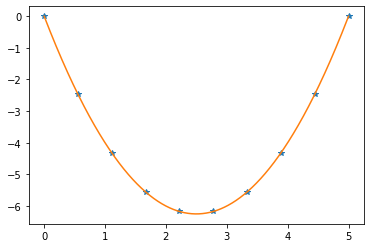

In [24]:
plt.plot(x, y, '*')
plt.plot(xnew, ynew)
plt.show()